In [26]:
import numpy as np
import pandas as pd
import seaborn as sns
import pingouin as pg
import ppscore as pps
import statsmodels.api as sm
import matplotlib.pyplot as plt
import feature_engine
from datetime import timedelta
from datetime import datetime
from sklearn.impute import SimpleImputer
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import sklearn
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.decomposition import PCA
from feature_engine.imputation import MeanMedianImputer
import math
import joblib
import pickle






In [27]:
excel_file_path = 'budgetusd.xlsx'
sheet_name = "Indirect_Expenses"
df = pd.read_excel(excel_file_path, sheet_name=sheet_name)
# Load the Excel file into a pandas DataFrame


In [28]:
# This function will remove decimal points

def round_up_numeric(value):
    if pd.notnull(value) and isinstance(value, (int, float)):
        return math.ceil(value * 100) / 100
    return value

df =  df.applymap(round_up_numeric)

In [29]:
# Convert 'Date' column to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Set 'Date' as the index
df.set_index('Date', inplace=True)


In [30]:
duplicate_cols = df.columns[df.columns.duplicated()]
print("Duplicate Columns:", duplicate_cols)

Duplicate Columns: Index([], dtype='object')


In [31]:
df.isnull().sum()

Resturant Revenue           0
Bar Revenue                 0
Rooms Revenue               0
Total Wages                 0
Maintenance                 0
Accounting Services         0
Admin Expenses              0
Utilities Expenses          0
Insuraces                   0
Systems & Communications    0
Transport                   0
Booking.com                 0
Marketing                   0
Comisiones POS              0
Total Indirect Costs        0
dtype: int64

/workspace/.pyenv_mirror/user/current/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


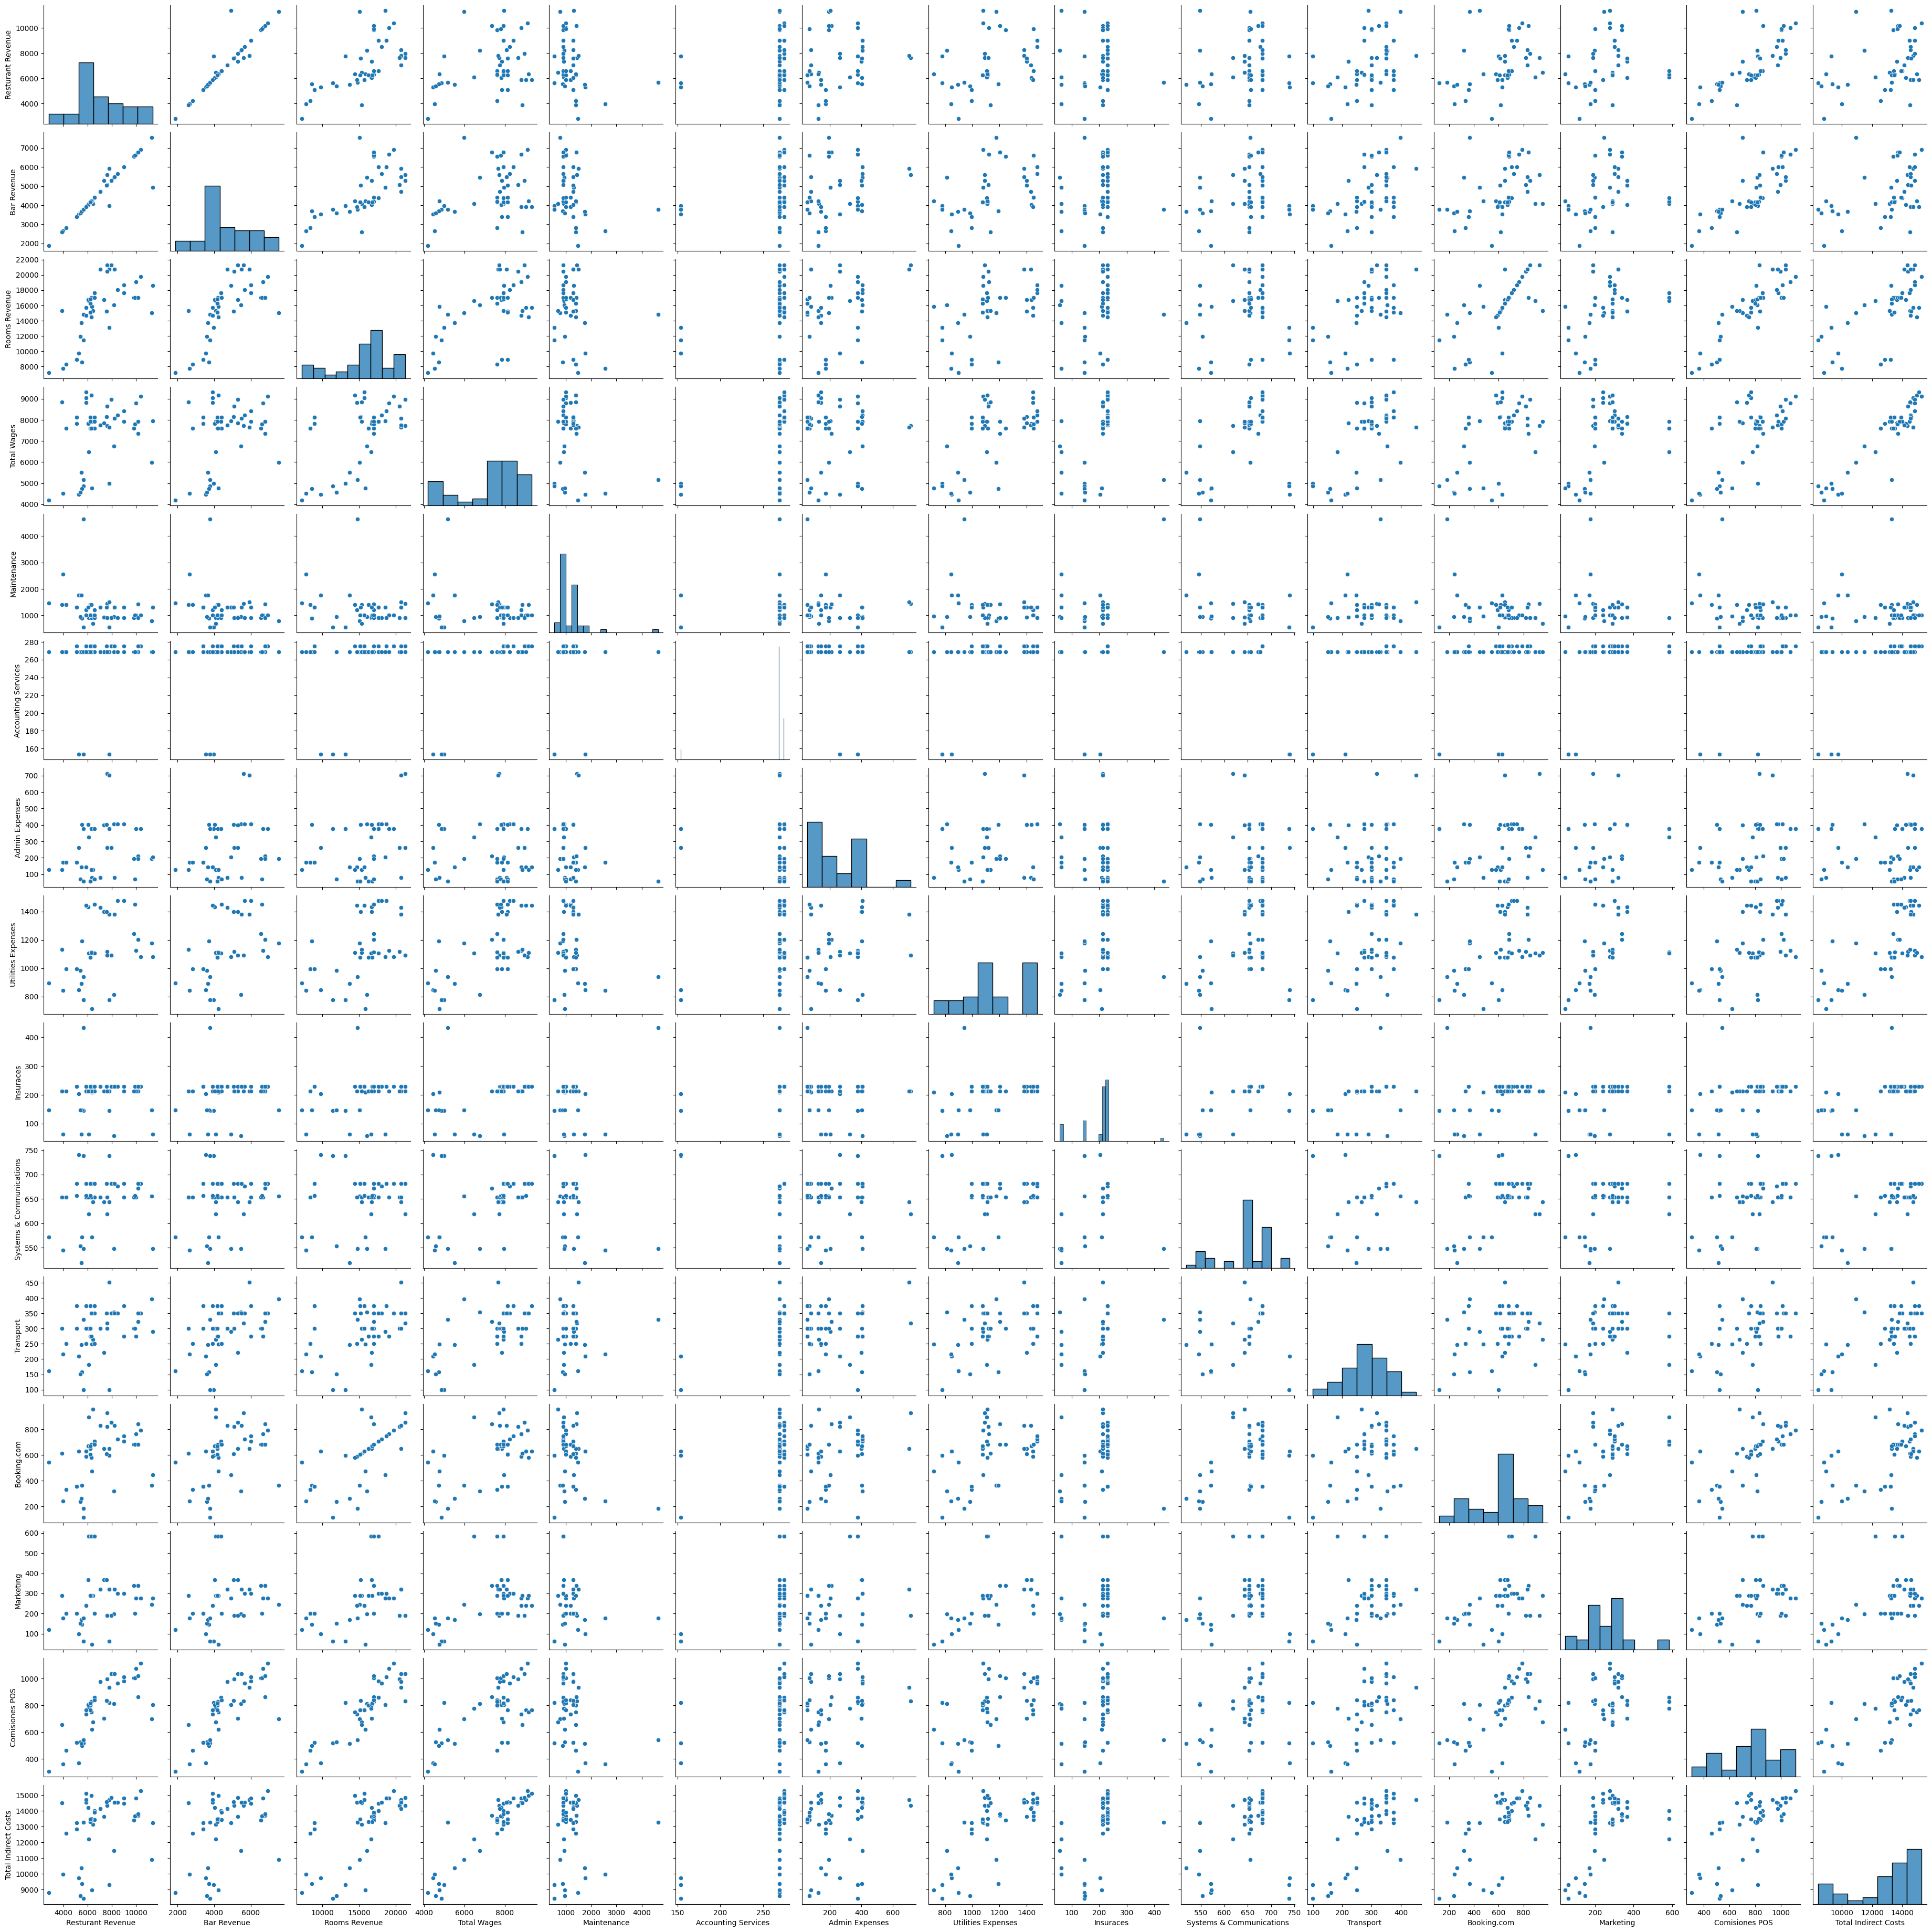

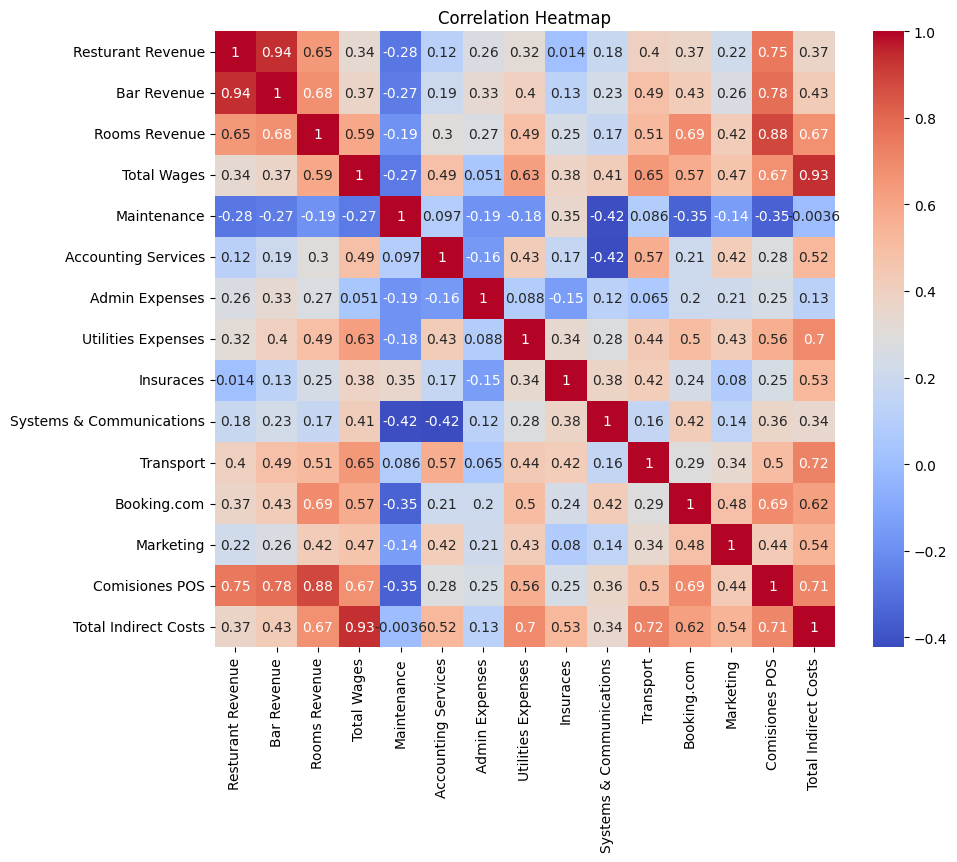

In [32]:
import seaborn as sns
import matplotlib.pyplot as plt

# Scatter plots for numerical variables
sns.pairplot(df, vars=['Resturant Revenue', 'Bar Revenue', 'Rooms Revenue', 'Total Wages', 
'Maintenance', 'Accounting Services', 'Admin Expenses', 'Utilities Expenses', 'Insuraces', 'Systems & Communications',
'Transport', 'Booking.com',	'Marketing', 'Comisiones POS', 'Total Indirect Costs'])
plt.show()

# Heatmap for numerical variable correlations
correlation_matrix = df.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title("Correlation Heatmap")
plt.show()



In [33]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 48 entries, 2022-01-01 to 2025-12-01
Data columns (total 15 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Resturant Revenue         48 non-null     float64
 1   Bar Revenue               48 non-null     float64
 2   Rooms Revenue             48 non-null     float64
 3   Total Wages               48 non-null     float64
 4   Maintenance               48 non-null     float64
 5   Accounting Services       48 non-null     float64
 6   Admin Expenses            48 non-null     float64
 7   Utilities Expenses        48 non-null     float64
 8   Insuraces                 48 non-null     float64
 9   Systems & Communications  48 non-null     float64
 10  Transport                 48 non-null     float64
 11  Booking.com               48 non-null     float64
 12  Marketing                 48 non-null     float64
 13  Comisiones POS            48 non-null     float

In [34]:
df

,Resturant Revenue,Bar Revenue,Rooms Revenue,Total Wages,Maintenance,Accounting Services,Admin Expenses,Utilities Expenses,Insuraces,Systems & Communications,Transport,Booking.com,Marketing,Comisiones POS,Total Indirect Costs
Date,,,,,,,,,,,,,,,
2022-01-01,7771.64,3972.56,13136.89,4982.91,552.78,153.67,375.92,778.34,145.75,738.31,98.73,597.31,62.12,819.00,9304.80
2022-02-01,5660.00,3773.34,11430.53,4875.05,552.78,153.67,375.92,778.34,145.75,738.31,98.73,117.67,62.12,519.45,8417.75
2022-03-01,5299.87,3533.23,9742.62,4455.03,1761.00,153.67,261.45,846.75,202.95,740.34,209.14,627.39,99.31,370.31,9727.31
2022-04-01,11300.75,7533.84,15043.81,5982.23,782.03,269.03,193.12,1176.39,146.17,655.78,397.28,362.98,246.06,700.00,10911.03
2022-05-01,5555.01,3703.34,8546.17,4734.98,878.69,269.03,401.15,1192.56,146.17,571.24,157.17,363.99,144.93,500.00,9359.87
2022-06-01,2822.00,1881.33,7171.42,4201.11,1472.23,269.03,126.45,896.39,146.17,571.24,161.50,543.12,118.46,305.56,8811.23
2022-07-01,6345.99,4230.66,15864.98,4752.31,965.24,269.03,78.94,715.28,209.79,571.86,249.67,476.30,46.77,617.98,8953.12
2022-08-01,5398.01,3598.67,11925.83,4571.36,952.55,269.03,70.70,982.28,147.40,553.02,151.67,239.14,149.97,527.78,8614.86
2022-09-01,5495.22,3663.48,13738.03,5522.15,1759.00,269.03,144.10,892.63,62.88,518.46,248.06,263.17,170.25,515.03,10364.71
